In [1]:
# Minimal setup: load table and define column names used below
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

# --- Config ---
CSV_PATH = r"C:\Users\Vex\Desktop\football\dataset\matchday\clean_matchday_stat.csv"

# --- Load ---
df = pd.read_csv(CSV_PATH)

# Column headers in your file (edit if your schema differs)
HOME = 'home_team'
AWAY = 'away_team'
FTHG = 'home_score'
FTAG = 'away_score'
XGH  = 'expected_goals_xg_home'
XGA  = 'expected_goals_xg_host'
ORDER_COL = '_order' if '_order' in df.columns else None

# Types/coercions needed later
d = df.copy()
for c in [FTHG, FTAG]:
    d[c] = pd.to_numeric(d[c], errors='coerce').fillna(0).astype(int)
for c in [XGH, XGA]:
    d[c] = pd.to_numeric(d[c], errors='coerce').astype(float)

# Create a chronological field if none exists
if ORDER_COL is None:
    if 'Date_day' in d.columns:
        d['_order'] = pd.to_datetime(d['Date_day'], errors='coerce')
    else:
        d['_order'] = np.arange(len(d))
ORDER_COL = '_order'

# Observed points (convert W/D/L to 3/1/0 for home/away)
home_pts = np.select([d[FTHG]>d[FTAG], d[FTHG]==d[FTAG], d[FTHG]<d[FTAG]], [3,1,0])
away_pts = np.select([d[FTHG]<d[FTAG], d[FTHG]==d[FTAG], d[FTHG]>d[FTAG]], [3,1,0])

# Expected result probabilities: prefer provided pW/pD/pL, otherwise Skellam from xG
if {'pW','pD','pL'}.issubset(d.columns):
    pW_home = pd.to_numeric(d['pW'], errors='coerce').to_numpy()
    pD_home = pd.to_numeric(d['pD'], errors='coerce').to_numpy()
    pL_home = pd.to_numeric(d['pL'], errors='coerce').to_numpy()
else:
    from scipy.stats import skellam
    lam_h = np.clip(pd.to_numeric(d[XGH], errors='coerce').to_numpy(dtype=float), 1e-8, None)
    lam_a = np.clip(pd.to_numeric(d[XGA], errors='coerce').to_numpy(dtype=float), 1e-8, None)
    pD_home = skellam.pmf(0, lam_h, lam_a)
    pH_home = 1.0 - skellam.cdf(0, lam_h, lam_a)  # P(home win)
    pA_home = 1.0 - (pH_home + pD_home)          # P(away win)
    pW_home, pL_home = pH_home, pA_home

# Assemble a tidy per-team sequence (home+away, ordered)
def team_series(team_name: str) -> pd.DataFrame:
    # Home rows for this team
    mH = (d[HOME]==team_name)
    subH = pd.DataFrame({
        'order': d.loc[mH, ORDER_COL].values,
        'opponent': d.loc[mH, AWAY].values,
        'venue': 'Home',
        'exp_win_prob': pW_home[mH].astype(float),
        'actual_win':   (home_pts[mH]==3).astype(int),
        'xg_for':       d.loc[mH, XGH].astype(float).values,
        'xg_against':   d.loc[mH, XGA].astype(float).values,
        'goals_for':    d.loc[mH, FTHG].astype(int).values,
        'goals_against':d.loc[mH, FTAG].astype(int).values
    })
    # Away rows (reuse home-model’s away-win prob)
    mA = (d[AWAY]==team_name)
    subA = pd.DataFrame({
        'order': d.loc[mA, ORDER_COL].values,
        'opponent': d.loc[mA, HOME].values,
        'venue': 'Away',
        'exp_win_prob': pL_home[mA].astype(float),
        'actual_win':   (away_pts[mA]==3).astype(int),
        'xg_for':       d.loc[mA, XGA].astype(float).values,
        'xg_against':   d.loc[mA, XGH].astype(float).values,
        'goals_for':    d.loc[mA, FTAG].astype(int).values,
        'goals_against':d.loc[mA, FTHG].astype(int).values
    })
    out = pd.concat([subH, subA], ignore_index=True).sort_values('order')
    out['match_idx'] = np.arange(1, len(out)+1)  # 1..N for x-axis
    return out.reset_index(drop=True)

# Fuzzy pick exact team names from table
def pick_exact(hint):
    pool = pd.Index(d[HOME]).append(pd.Index(d[AWAY])).unique().astype(str)
    m = [t for t in pool if hint.lower() in t.lower()]
    return m[0] if m else hint

TEAM_BAY = pick_exact("Bayern")
TEAM_LEV = pick_exact("Leverkusen")

bay = team_series(TEAM_BAY)
lev = team_series(TEAM_LEV)


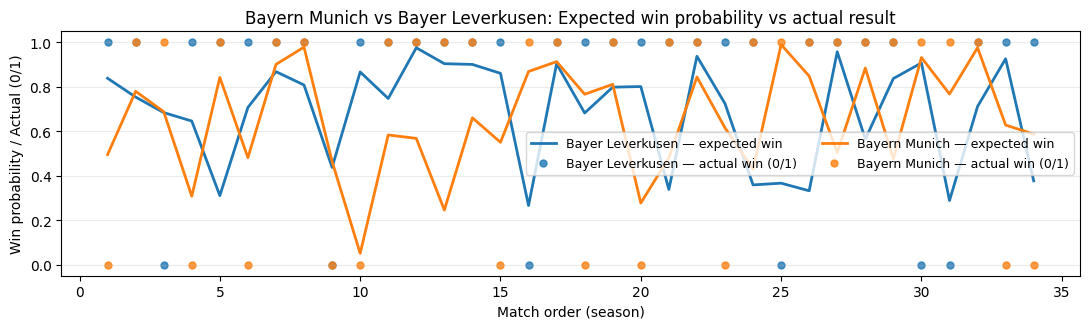

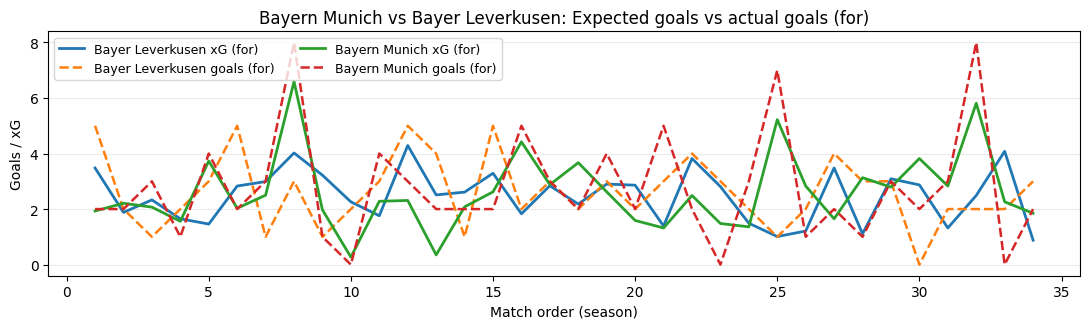

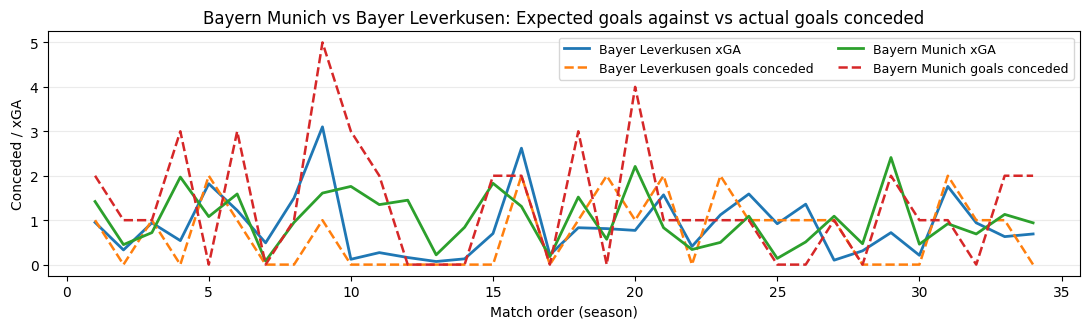

In [2]:
# A) Expected win probability vs actual 0/1
plt.figure(figsize=(11, 3.4))
plt.plot(lev['match_idx'], lev['exp_win_prob'], label=f"{TEAM_LEV} — expected win", lw=2)
plt.scatter(lev['match_idx'], lev['actual_win'], s=25, alpha=0.8, label=f"{TEAM_LEV} — actual win (0/1)")
plt.plot(bay['match_idx'], bay['exp_win_prob'], label=f"{TEAM_BAY} — expected win", lw=2)
plt.scatter(bay['match_idx'], bay['actual_win'], s=25, alpha=0.8, label=f"{TEAM_BAY} — actual win (0/1)")
plt.ylabel("Win probability / Actual (0/1)")
plt.xlabel("Match order (season)")
plt.title(f"{TEAM_BAY} vs {TEAM_LEV}: Expected win probability vs actual result")
plt.grid(True, axis='y', alpha=0.25)
plt.legend(ncol=2, fontsize=9)
plt.tight_layout()
plt.show()

# B) xG (for) vs goals scored
plt.figure(figsize=(11, 3.4))
plt.plot(lev['match_idx'], lev['xg_for'], label=f"{TEAM_LEV} xG (for)", lw=2)
plt.plot(lev['match_idx'], lev['goals_for'], '--', label=f"{TEAM_LEV} goals (for)", lw=1.8)
plt.plot(bay['match_idx'], bay['xg_for'], label=f"{TEAM_BAY} xG (for)", lw=2)
plt.plot(bay['match_idx'], bay['goals_for'], '--', label=f"{TEAM_BAY} goals (for)", lw=1.8)
plt.ylabel("Goals / xG")
plt.xlabel("Match order (season)")
plt.title(f"{TEAM_BAY} vs {TEAM_LEV}: Expected goals vs actual goals (for)")
plt.grid(True, axis='y', alpha=0.25)
plt.legend(ncol=2, fontsize=9)
plt.tight_layout()
plt.show()

# C) xGA vs goals conceded
plt.figure(figsize=(11, 3.4))
plt.plot(lev['match_idx'], lev['xg_against'], label=f"{TEAM_LEV} xGA", lw=2)
plt.plot(lev['match_idx'], lev['goals_against'], '--', label=f"{TEAM_LEV} goals conceded", lw=1.8)
plt.plot(bay['match_idx'], bay['xg_against'], label=f"{TEAM_BAY} xGA", lw=2)
plt.plot(bay['match_idx'], bay['goals_against'], '--', label=f"{TEAM_BAY} goals conceded", lw=1.8)
plt.ylabel("Conceded / xGA")
plt.xlabel("Match order (season)")
plt.title(f"{TEAM_BAY} vs {TEAM_LEV}: Expected goals against vs actual goals conceded")
plt.grid(True, axis='y', alpha=0.25)
plt.legend(ncol=2, fontsize=9)
plt.tight_layout()
plt.show()


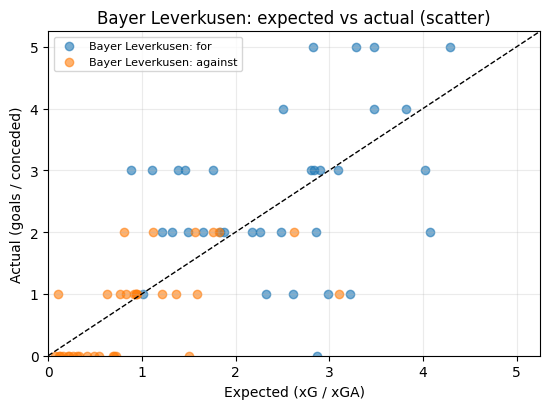

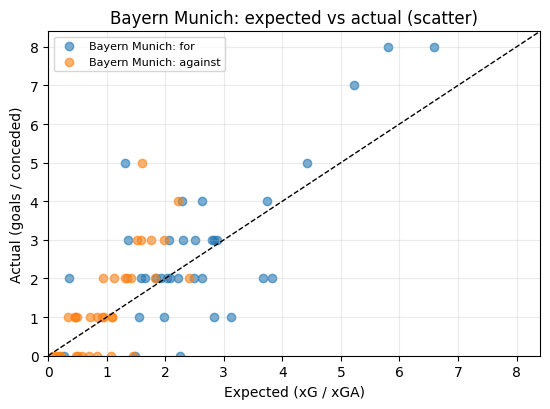

In [3]:
# Quick diagnostic: actual vs expected with identity line
def team_scatter(tb, tname):
    plt.figure(figsize=(5.6, 4.2))
    plt.scatter(tb['xg_for'], tb['goals_for'], alpha=0.6, label=f"{tname}: for")
    plt.scatter(tb['xg_against'], tb['goals_against'], alpha=0.6, label=f"{tname}: against")
    lim = (0, max(tb[['xg_for','goals_for','xg_against','goals_against']]
                  .to_numpy().ravel())*1.05)
    plt.plot(lim, lim, 'k--', lw=1)  # 45° reference
    plt.xlim(lim); plt.ylim(lim)
    plt.xlabel("Expected (xG / xGA)")
    plt.ylabel("Actual (goals / conceded)")
    plt.title(f"{tname}: expected vs actual (scatter)")
    plt.grid(True, alpha=0.25); plt.legend(fontsize=8)
    plt.tight_layout(); plt.show()

team_scatter(lev, TEAM_LEV)
team_scatter(bay, TEAM_BAY)


In [4]:
# Resolve common aliases once and build team-long + per-team aggregates
aliases = {
    "home_team": ["home_team","HomeTeam","home","Home"],
    "away_team": ["away_team","AwayTeam","away","Away"],
    "home_score": ["home_score","FTHG","HomeGoals","home_final_goal","home_fulltime_goals"],
    "away_score": ["away_score","FTAG","AwayGoals","away_final_goal","away_fulltime_goals"],
    "xg_home": ["expected_goals_xg_home","home_xg","xg_home","Home_xG"],
    "xg_away": ["expected_goals_xg_host","away_xg","xg_away","Away_xG"],
    "pos_home": ["Ball_Possession_Home","Possession_Home"],
    "pos_away": ["Ball_Possession_Host","Possession_Host"],
    "sog_home": ["Shots_on_Goal_Home","Shots_On_Goal_Home"],
    "sog_away": ["Shots_on_Goal_Host","Shots_On_Goal_Host"],
    "shots_home": ["Goal_Attempts_Home","Total_Shots_Home","Shots_Home"],
    "shots_away": ["Goal_Attempts_Host","Total_Shots_Host","Shots_Host"],
    "corn_home": ["Corner_Kicks_Home","Corners_Home"],
    "corn_away": ["Corner_Kicks_Host","Corners_Away","Corners_Host"],
    "fk_home": ["Free_Kicks_Home"],
    "fk_away": ["Free_Kicks_Host"],
    "saves_home": ["Goalkeeper_Saves_Home","Saves_Home"],
    "saves_away": ["Goalkeeper_Saves_Host","Saves_Away","Saves_Host"],
    "pass_tot_home": ["Total_Passes_Home"],
    "pass_tot_away": ["Total_Passes_Host"],
    "pass_cmp_home": ["Completed_Passes_Home"],
    "pass_cmp_away": ["Completed_Passes_Host"],
    "dang_home": ["Dangerous_Attacks_Home"],
    "dang_away": ["Dangerous_Attacks_Host"],
    "goal_times_home": ["home_team_goals_current_time"],
    "goal_times_away": ["away_team_goals_current_time"],
}
res = {}
for k, opts in aliases.items():
    for c in opts:
        if c in df.columns:
            res[k] = c
            break

required = ["home_team","away_team","home_score","away_score","xg_home","xg_away"]
if not all(k in res for k in required):
    raise ValueError(f"Missing essentials; resolved={res}")

H,A = res["home_team"], res["away_team"]
FTHG, FTAG = res["home_score"], res["away_score"]
XGH,  XGA  = res["xg_home"],   res["xg_away"]

# Ensure numeric bases
for c in [FTHG,FTAG,XGH,XGA]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

def _num(c): 
    return pd.to_numeric(df[c], errors="coerce") if c in df.columns else None

posH, posA = (_num(res.get("pos_home")), _num(res.get("pos_away")))
sogH, sogA = (_num(res.get("sog_home")), _num(res.get("sog_away")))
shtH, shtA = (_num(res.get("shots_home")), _num(res.get("shots_away")))
corH, corA = (_num(res.get("corn_home")), _num(res.get("corn_away")))
fkH,  fkA  = (_num(res.get("fk_home")),  _num(res.get("fk_away")))
savH, savA = (_num(res.get("saves_home")), _num(res.get("saves_away")))
ptH,  ptA  = (_num(res.get("pass_tot_home")), _num(res.get("pass_tot_away")))
pcH,  pcA  = (_num(res.get("pass_cmp_home")), _num(res.get("pass_cmp_away")))
dangH,dangA= (_num(res.get("dang_home")), _num(res.get("dang_away")))

# Team-perspective long table (home→away mirror for opponent values)
home = pd.DataFrame({
    "team": df[H], "opponent": df[A], "venue":"Home",
    "gf": df[FTHG], "ga": df[FTAG], "xg_for": df[XGH], "xg_against": df[XGA],
    "pos": posH, "sog": sogH, "shots": shtH, "corners": corH, "fks": fkH,
    "saves": savH, "pass_tot": ptH, "pass_cmp": pcH, "dang": dangH
})
away = pd.DataFrame({
    "team": df[A], "opponent": df[H], "venue":"Away",
    "gf": df[FTAG], "ga": df[FTHG], "xg_for": df[XGA], "xg_against": df[XGH],
    "pos": posA, "sog": sogA, "shots": shtA, "corners": corA, "fks": fkA,
    "saves": savA, "pass_tot": ptA, "pass_cmp": pcA, "dang": dangA
})
long = pd.concat([home,away], ignore_index=True)
long["pts"] = np.select([long["gf"]>long["ga"], long["gf"]==long["ga"], long["gf"]<long["ga"]],[3,1,0])

def _against(colname):
    if colname not in long.columns: return None
    vals_home = home[colname].to_numpy()
    vals_away = away[colname].to_numpy()
    return np.concatenate([vals_away, vals_home])  # opponent value for each entry

dang_against = _against("dang")
sog_against  = _against("sog")

# Derived shares/ratios if inputs exist
if ("dang" in long.columns) and (dang_against is not None):
    da_for = long["dang"].to_numpy(dtype=float)
    da_ag  = dang_against.astype(float)
    long["field_tilt"] = da_for / np.clip(da_for + da_ag, 1e-6, None)
if ("saves" in long.columns) and (sog_against is not None):
    long["save_rate"] = long["saves"] / np.clip(sog_against.astype(float), 1e-6, None)
if ("pass_tot" in long.columns) and ("pass_cmp" in long.columns):
    long["pass_pct"] = long["pass_cmp"] / np.clip(long["pass_tot"], 1e-6, None)

# Late-goal share (≥88′) per team, if goal-time strings available
def parse_minutes(col):
    if col not in df.columns: return None
    mins_all = []
    for s in df[col].fillna("[]").astype(str):
        mins = []
        for m in re.findall(r"(\d+)(?:\+(\d+))?'", s):
            base = int(m[0]); plus = int(m[1]) if m[1] not in (None,'') else 0
            mins.append(base + plus)
        mins_all.append(mins)
    return mins_all

home_goal_mins = parse_minutes(res.get("goal_times_home","__none__"))
away_goal_mins = parse_minutes(res.get("goal_times_away","__none__"))

late_share = None
if home_goal_mins is not None and away_goal_mins is not None:
    def count_late(mins, thr=88): 
        return sum(m >= thr for m in mins)
    hg, ag, hl, al = [], [], [], []
    for hm, am in zip(home_goal_mins, away_goal_mins):
        hg.append(len(hm)); ag.append(len(am))
        hl.append(count_late(hm)); al.append(count_late(am))
    late_home = pd.DataFrame({"team": df[H], "goals": hg, "late": hl})
    late_away = pd.DataFrame({"team": df[A], "goals": ag, "late": al})
    late = pd.concat([late_home, late_away], ignore_index=True)
    late_share = (late.groupby("team", as_index=False).sum(numeric_only=True))
    late_share["late_share"] = late_share["late"] / np.clip(late_share["goals"], 1e-6, None)

# Aggregate per team (season level)
agg = (long.groupby("team", as_index=False)
            .agg(matches=("pts","size"),
                 pts=("pts","sum"),
                 xg_for=("xg_for","sum"),
                 xg_against=("xg_against","sum"),
                 gf=("gf","sum"), ga=("ga","sum"),
                 pos=("pos","mean"),
                 shots=("shots","mean"),
                 sog=("sog","mean"),
                 corners=("corners","mean"),
                 fks=("fks","mean"),
                 pass_pct=("pass_pct","mean"),
                 field_tilt=("field_tilt","mean"),
                 save_rate=("save_rate","mean"))
      )
agg["g_minus_xg"] = agg["gf"] - agg["xg_for"]
agg["ga_minus_xga"] = agg["ga"] - agg["xg_against"]
if late_share is not None:
    agg = agg.merge(late_share[["team","late_share"]], on="team", how="left")


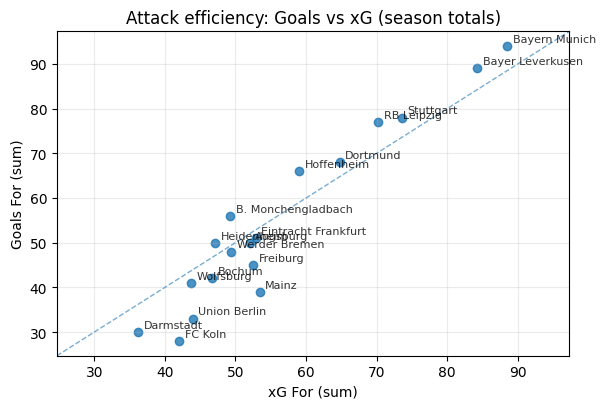

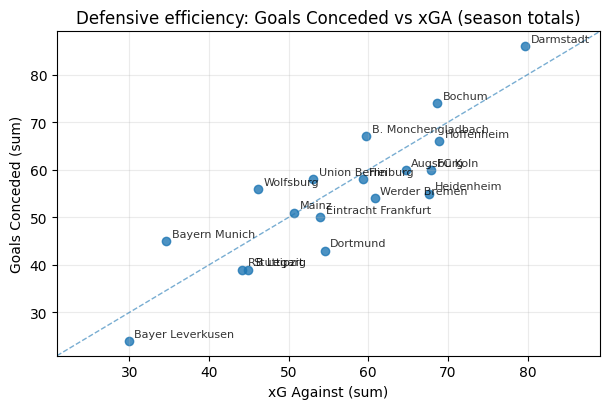

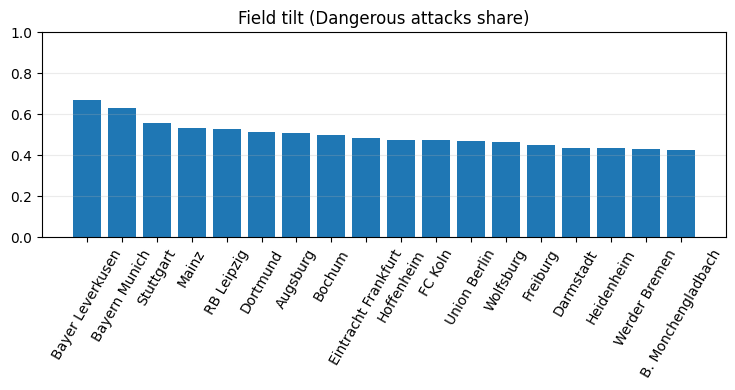

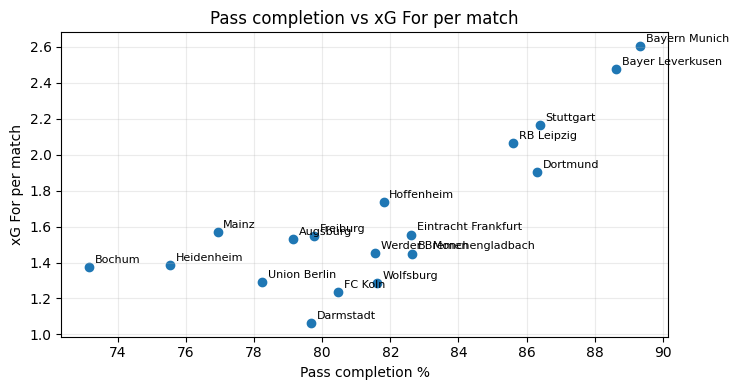

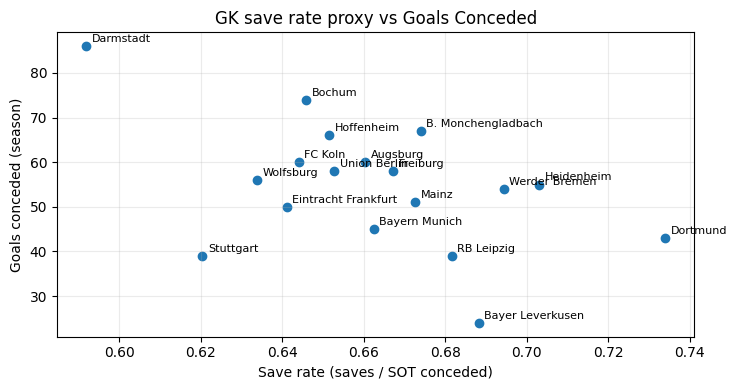

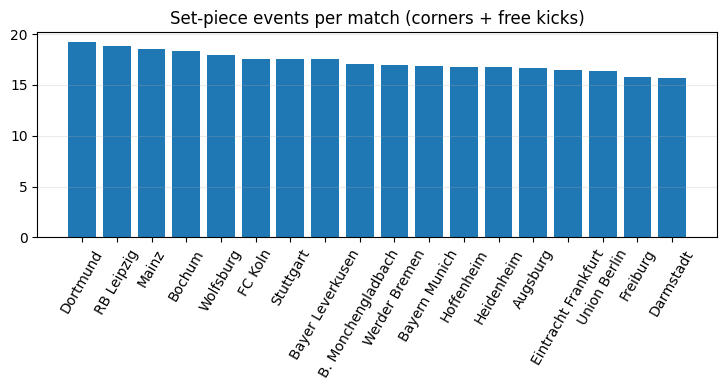

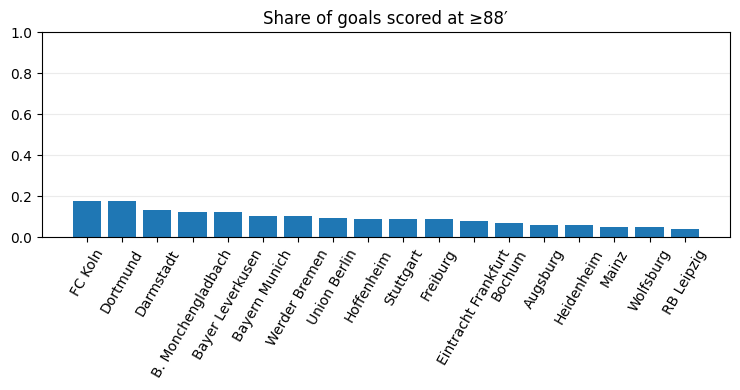

In [5]:
# Small helper: scatter with 45° reference and team labels
def scatter_with_45(x, y, labels, title, xlabel, ylabel):
    plt.figure(figsize=(6.2, 4.2))
    plt.scatter(x, y, alpha=0.8)
    lo = min(np.nanmin(x), np.nanmin(y))
    hi = max(np.nanmax(x), np.nanmax(y))
    pad = (hi-lo)*0.05 if np.isfinite([lo,hi]).all() else 1.0
    lo -= pad; hi += pad
    plt.plot([lo,hi],[lo,hi], lw=1, ls="--", alpha=0.6)
    plt.xlim(lo,hi); plt.ylim(lo,hi)
    plt.title(title); plt.xlabel(xlabel); plt.ylabel(ylabel)
    for xi, yi, s in zip(x, y, labels):
        if np.isfinite(xi) and np.isfinite(yi):
            plt.annotate(str(s), (xi, yi), xytext=(4,3), textcoords="offset points", fontsize=8, alpha=0.8)
    plt.grid(True, alpha=0.25)
    plt.tight_layout(); plt.show()

# Figure 1 (left): xG For vs Goals For
if {"xg_for","gf"}.issubset(agg.columns):
    scatter_with_45(agg["xg_for"], agg["gf"], agg["team"],
                    "Attack efficiency: Goals vs xG (season totals)",
                    "xG For (sum)", "Goals For (sum)")

# Figure 1 (right): xGA vs GA
if {"xg_against","ga"}.issubset(agg.columns):
    scatter_with_45(agg["xg_against"], agg["ga"], agg["team"],
                    "Defensive efficiency: Goals Conceded vs xGA (season totals)",
                    "xG Against (sum)", "Goals Conceded (sum)")

# Figure 2a: Field tilt
if "field_tilt" in agg.columns and agg["field_tilt"].notna().any():
    plt.figure(figsize=(7.5, 4))
    at = agg.sort_values("field_tilt", ascending=False)
    plt.bar(at["team"], at["field_tilt"])
    plt.title("Field tilt (Dangerous attacks share)")
    plt.ylim(0,1); plt.xticks(rotation=60); plt.grid(True, axis="y", alpha=0.25)
    plt.tight_layout(); plt.show()

# Figure 2b: Pass % vs xG For per match
if {"pass_pct","xg_for"}.issubset(agg.columns) and agg["pass_pct"].notna().any():
    plt.figure(figsize=(7.5, 4))
    plt.scatter(agg["pass_pct"]*100, agg["xg_for"]/agg["matches"])
    for xi, yi, s in zip(agg["pass_pct"]*100, agg["xg_for"]/agg["matches"], agg["team"]):
        if np.isfinite(xi) and np.isfinite(yi):
            plt.annotate(str(s), (xi, yi), xytext=(4,3), textcoords="offset points", fontsize=8)
    plt.title("Pass completion vs xG For per match")
    plt.xlabel("Pass completion %"); plt.ylabel("xG For per match")
    plt.grid(True, alpha=0.25); plt.tight_layout(); plt.show()

# Figure 2c: Save rate vs GA
if "save_rate" in agg.columns and agg["save_rate"].notna().any():
    plt.figure(figsize=(7.5, 4))
    plt.scatter(agg["save_rate"], agg["ga"])
    for xi, yi, s in zip(agg["save_rate"], agg["ga"], agg["team"]):
        if np.isfinite(xi) and np.isfinite(yi):
            plt.annotate(str(s), (xi, yi), xytext=(4,3), textcoords="offset points", fontsize=8)
    plt.title("GK save rate proxy vs Goals Conceded")
    plt.xlabel("Save rate (saves / SOT conceded)"); plt.ylabel("Goals conceded (season)")
    plt.grid(True, alpha=0.25); plt.tight_layout(); plt.show()

# Figure 3a: Set-piece events per match
if {"corners","fks"}.issubset(long.columns):
    sp = (long.groupby("team", as_index=False)
               .agg(corners=("corners","mean"), fks=("fks","mean")))
    sp["setpiece_events_per_match"] = sp["corners"] + sp["fks"]
    sp = sp.sort_values("setpiece_events_per_match", ascending=False)
    plt.figure(figsize=(7.5, 4))
    plt.bar(sp["team"], sp["setpiece_events_per_match"])
    plt.title("Set-piece events per match (corners + free kicks)")
    plt.xticks(rotation=60); plt.grid(True, axis="y", alpha=0.25)
    plt.tight_layout(); plt.show()

# Figure 3b: Late goal share (≥88′)
if "late_share" in agg.columns and agg["late_share"].notna().any():
    ls = agg.sort_values("late_share", ascending=False)
    plt.figure(figsize=(7.5, 4))
    plt.bar(ls["team"], ls["late_share"])
    plt.title("Share of goals scored at ≥88′")
    plt.ylim(0, 1); plt.xticks(rotation=60); plt.grid(True, axis="y", alpha=0.25)
    plt.tight_layout(); plt.show()


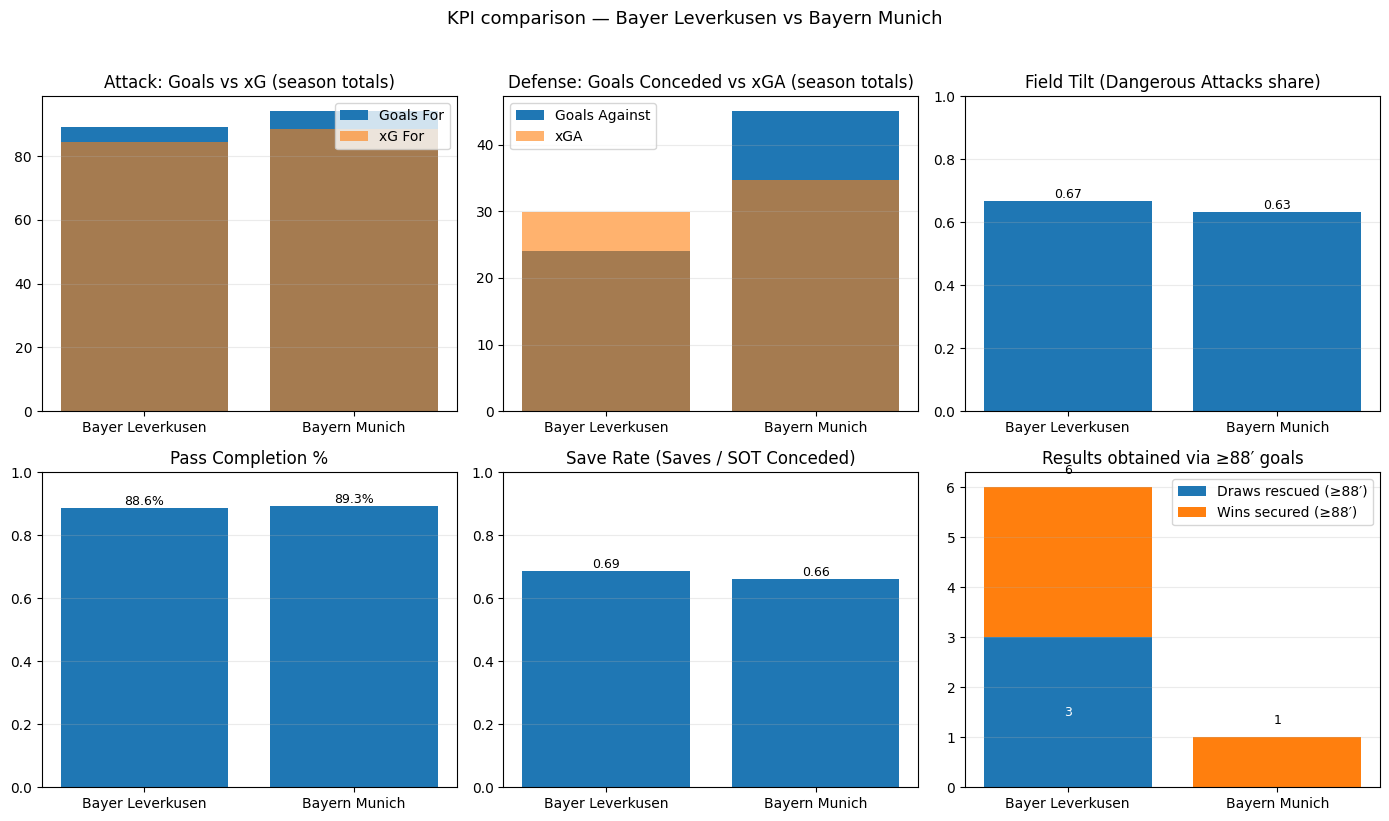

In [6]:
# Compare Leverkusen vs Bayern on a small set of KPIs (single figure)
import numpy as np
import matplotlib.pyplot as plt
import re
import pandas as pd

# Names by substring match (uses `long` from Cell 4)
def pick_name(names, hint):
    m = [t for t in names if isinstance(t, str) and hint.lower() in t.lower()]
    return m[0] if m else None

teams_all = sorted(long["team"].dropna().unique())
TEAM_L = pick_name(teams_all, "Leverkusen") or "Bayer Leverkusen"
TEAM_B = pick_name(teams_all, "Bayern")     or "Bayern Munich"

# Two-team aggregate slice
agg2 = (long[long["team"].isin([TEAM_L, TEAM_B])]
        .groupby("team", as_index=False)
        .agg(matches=("pts","size"),
             pts=("pts","sum"),
             xg_for=("xg_for","sum"),
             xg_against=("xg_against","sum"),
             gf=("gf","sum"), ga=("ga","sum"),
             pass_pct=("pass_pct","mean"),
             field_tilt=("field_tilt","mean"),
             save_rate=("save_rate","mean"))
       )

# Small helper: labeled bars with value text
def bar2(ax, df2, col, title, fmt="{:.2f}", ylim=None, pct=False):
    if col not in df2.columns or df2[col].isna().all():
        ax.axis("off"); ax.text(0.5,0.5,f"{col} not available", ha="center"); return
    s = df2.set_index("team")[col].reindex([TEAM_L, TEAM_B])
    bars = ax.bar(s.index, s.values)
    for b, v in zip(bars, s.values):
        txt = (fmt.format(v*100) + "%") if pct else fmt.format(v)
        ax.text(b.get_x()+b.get_width()/2, b.get_height(), txt,
                ha="center", va="bottom", fontsize=9)
    ax.set_title(title)
    if ylim: ax.set_ylim(*ylim)
    ax.grid(True, axis="y", alpha=0.25)
    ax.tick_params(axis="x", rotation=0)

# Late results due to ≥88′ goals (optional, if goal-time strings exist)
def late_results_counts():
    gh, ga = res.get("goal_times_home"), res.get("goal_times_away")
    if gh not in df.columns or ga not in df.columns:
        return None, None

    def parse(col):
        mins_all = []
        for s in df[col].fillna("[]").astype(str):
            mins = []
            for m in re.findall(r"(\d+)(?:\+(\d+))?'", s):
                base = int(m[0]); plus = int(m[1]) if m[1] not in (None,'') else 0
                mins.append(base + plus)
            mins_all.append(mins)
        return mins_all

    Hmins, Amins = parse(gh), parse(ga)
    wins = {TEAM_L:0, TEAM_B:0}
    draws = {TEAM_L:0, TEAM_B:0}

    for hm, am, h, a, hg, ag in zip(Hmins, Amins, df[H], df[A], df[FTHG], df[FTAG]):
        def late_count(mins): return sum(m>=88 for m in mins)
        hg_no_late = max(int(hg) - late_count(hm), 0)
        ag_no_late = max(int(ag) - late_count(am), 0)

        # Home outcome now vs removing ≥88′ goals
        res_now_home = 1 if hg>ag else (0 if hg==ag else -1)
        res_old_home = 1 if hg_no_late>ag_no_late else (0 if hg_no_late==ag_no_late else -1)

        # Check if late goals improved result
        if res_now_home > res_old_home:
            if h in draws and res_now_home==0 and res_old_home==-1: draws[h]+=1
            if h in wins  and res_now_home==1 and res_old_home<=0:  wins[h]+=1

        # Mirror for away team
        if (-res_now_home) > (-res_old_home):
            if a in draws and res_now_home==0 and res_old_home==1:  draws[a]+=1
            if a in wins  and res_now_home==-1 and res_old_home>=0: wins[a]+=1

    return wins, draws

wins_via_late, draws_via_late = late_results_counts()

# --- 2×3 grid ---
fig, axes = plt.subplots(2, 3, figsize=(14,8))

# (1) Goals vs xG (attack)
if {"gf","xg_for"}.issubset(agg2.columns):
    s = agg2.set_index("team").reindex([TEAM_L, TEAM_B])
    ax = axes[0,0]
    ax.bar(s.index, s["gf"], label="Goals For")
    ax.bar(s.index, s["xg_for"], alpha=0.6, label="xG For")
    ax.set_title("Attack: Goals vs xG (season totals)")
    ax.legend(); ax.grid(True, axis="y", alpha=0.25)
else:
    axes[0,0].axis("off"); axes[0,0].text(0.5,0.5,"Missing GF/xG", ha="center")

# (2) Goals conceded vs xGA (defense)
if {"ga","xg_against"}.issubset(agg2.columns):
    s = agg2.set_index("team").reindex([TEAM_L, TEAM_B])
    ax = axes[0,1]
    ax.bar(s.index, s["ga"], label="Goals Against")
    ax.bar(s.index, s["xg_against"], alpha=0.6, label="xGA")
    ax.set_title("Defense: Goals Conceded vs xGA (season totals)")
    ax.legend(); ax.grid(True, axis="y", alpha=0.25)
else:
    axes[0,1].axis("off"); axes[0,1].text(0.5,0.5,"Missing GA/xGA", ha="center")

# (3) Field tilt
bar2(axes[0,2], agg2, "field_tilt", "Field Tilt (Dangerous Attacks share)", fmt="{:.2f}", ylim=(0,1))

# (4) Pass completion %
bar2(axes[1,0], agg2, "pass_pct", "Pass Completion %", fmt="{:.1f}", ylim=(0,1), pct=True)

# (5) Save rate
bar2(axes[1,1], agg2, "save_rate", "Save Rate (Saves / SOT Conceded)", fmt="{:.2f}", ylim=(0,1))

# (6) Results via ≥88′ goals (stacked)
ax = axes[1,2]
if wins_via_late is not None and draws_via_late is not None:
    labels = [TEAM_L, TEAM_B]
    wins  = [wins_via_late.get(TEAM_L,0), wins_via_late.get(TEAM_B,0)]
    draws = [draws_via_late.get(TEAM_L,0), draws_via_late.get(TEAM_B,0)]
    x = np.arange(len(labels))
    ax.bar(x, draws, label="Draws rescued (≥88′)")
    ax.bar(x, wins, bottom=draws, label="Wins secured (≥88′)")
    for i,(d_,w_) in enumerate(zip(draws,wins)):
        if d_>0: ax.text(i, d_/2, f"{d_}", ha="center", va="center", color="white", fontsize=9)
        ax.text(i, d_+w_ + 0.2, f"{d_+w_}", ha="center", va="bottom", fontsize=9)
    ax.set_xticks(x); ax.set_xticklabels(labels)
    ax.set_title("Results obtained via ≥88′ goals")
    ax.grid(True, axis="y", alpha=0.25); ax.legend()
else:
    ax.axis("off"); ax.text(0.5,0.5,"No goal-time strings → late-results panel omitted", ha="center")

fig.suptitle(f"KPI comparison — {TEAM_L} vs {TEAM_B}", fontsize=13, y=1.02)
fig.tight_layout()
plt.show()
